In [1]:
import os, dill
from dev.constants import data_storage

import pandas as pd
import torch as t
import umap

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = f"{data_storage}/climatex/embeddings"


def get_umap(report: str) -> pd.DataFrame:
    files = [f for f in os.listdir(path) if report in f]
    data, tags, topics = [], [], []
    for file in files:
        data.append(t.load(f"{path}/{file}", pickle_module=dill))
        topic_file = file.replace(".pt", "_topics.jsonl")
        df = pd.read_json(f"{data_storage}/climatex/topics/{topic_file}", orient="records", lines=True)
        tags.extend(df["tag"].tolist())
        topics.extend(df["topic"].tolist())

    data = t.concat(data)
    reducer = umap.UMAP(n_components=2)
    data = reducer.fit_transform(data)
    df = pd.DataFrame()
    df["tag"] = tags
    df["topic"] = topics
    df["x"] = data[:, 0]
    df["y"] = data[:, 1]

    return df

In [3]:
umaps = [get_umap(report) for report in ["AR3", "AR4", "AR5", "AR6"]]

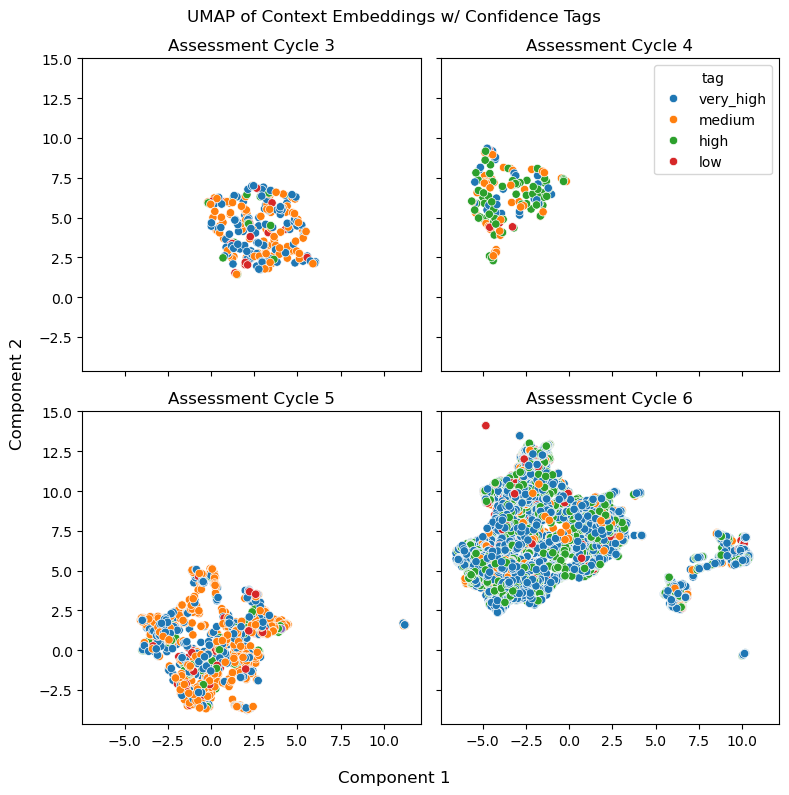

In [5]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 8))
axes = axes.flatten()

titles = [f"Assessment Cycle {i}" for i in range(3, 7)]
for i in range(4):
    axes[i].set_title(titles[i])
    legend = "auto" if i == 1 else False 
    sns.scatterplot(data=umaps[i], x="x", y="y", hue="tag", ax=axes[i], legend=legend)
    axes[i].set_xlabel(""); axes[i].set_ylabel("")

fig.supxlabel("Component 1")
fig.supylabel("Component 2")
fig.suptitle("UMAP of Context Embeddings w/ Confidence Tags")
plt.tight_layout()
plt.savefig(f"{data_storage}/climatex/topic-umap.png", dpi=400)
plt.show()